In [1]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import pandas as pd
import numpy as np
import warnings
import mlflow
from modeling.config import TRACKING_URI, EXPERIMENT_NAME

RSEED = 42
# Modeling Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.dummy import DummyClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression



warnings.filterwarnings('ignore')


In [2]:
df_features = pd.read_csv('../data/Flu_Shot_Learning_Predict_H1N1_and_Seasonal_Flu_Vaccines_-_Training_Features.csv')

In [3]:
df_target = pd.read_csv('../data/Flu_Shot_Learning_Predict_H1N1_and_Seasonal_Flu_Vaccines_-_Training_Labels.csv')

In [4]:
# Get info for the target
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   respondent_id     26707 non-null  int64
 1   h1n1_vaccine      26707 non-null  int64
 2   seasonal_vaccine  26707 non-null  int64
dtypes: int64(3)
memory usage: 626.1 KB


In [5]:
df_features.isnull().sum(axis = 0)

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

- express missing values as %

Options:
- modelling for imputation (withput using our target variable!)
- or use prediction models that don't care about missing values
- or impute so that the overall distribution stays the same (based on statistics of this data set)
- or impute using a hypothesis (e.g. people who have missing values don't have health insurance?)
- for imputation we can try several approaches and see what gives best results :)

- remember--when we impute, we want to base assumptions based on the test set of a train-test split:
    - if we do multiple models, test-train split for each
    - create functions for imputation

- remember modelling for understanding (EDA style) =/= modelling for prediction

library for visualising missing values:  

https://github.com/ResidentMario/missingno

In [6]:
# We are concatenating both dataframes into one 

df = pd.merge(df_target, df_features, on=['respondent_id'])

# Data imputation

These count as columns that were dropped last time, with "too many missing values":
['health_insurance', 'employment_industry', 'employment_occupation', 'income_poverty', 'marital_status', 'employment_status']

To try:  
- imputation on whole DF, most common values
- imputation on whole DF (feature by feature), fill values but keep data distribution (e.g. 90% of values are 1, 10% of values are 0)
- model to predict missing values:
    - this is most important for health_insurance: 45% values are missing, but it's likely to be important to us
    - income_poverty could also be important
    - employment_occupation and employment_industry have many missing values, but their contents are not very useful (anonymised, we can't really make sense of them)--these features could be dropped

To note:
- prior to doing imputation models, I need to make sure the rest of the data is clean (or use a model which isn't impacted by missing data)
- I may need a combination strategy to tacle this (e.g. using a model to impute some features and filling other features in with their most common value)

How to assess imputation strategy:
- What were the final model evaluation metrics before and after imputation?
- Did overall statistics of the imputed features stay the same?
- What about their correlations to other features?

### Info:  
- https://machinelearningmastery.com/statistical-imputation-for-missing-values-in-machine-learning/

Statistics of features, before imputation:

In [7]:
df.describe()

,respondent_id,h1n1_vaccine,seasonal_vaccine,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,26707.000000,26707.000000,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,...,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000
mean,13353.000000,0.212454,0.465608,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,...,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583
std,7709.791156,0.409052,0.498825,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,...,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,6676.500000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,...,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,13353.000000,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,...,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,20029.500000,0.000000,1.000000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,...,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,26706.000000,1.000000,1.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


How many values are missing? (expressed as %)

In [7]:
round(df.isnull().sum(axis = 0) / df.shape[0] *100, 2).sort_values(ascending=False)

employment_occupation          50.44
employment_industry            49.91
health_insurance               45.96
income_poverty                 16.56
doctor_recc_h1n1                8.09
doctor_recc_seasonal            8.09
rent_or_own                     7.65
employment_status               5.48
marital_status                  5.27
education                       5.27
chronic_med_condition           3.64
child_under_6_months            3.07
health_worker                   3.01
opinion_seas_sick_from_vacc     2.01
opinion_seas_risk               1.92
opinion_seas_vacc_effective     1.73
opinion_h1n1_sick_from_vacc     1.48
opinion_h1n1_vacc_effective     1.46
opinion_h1n1_risk               1.45
household_children              0.93
household_adults                0.93
behavioral_avoidance            0.78
behavioral_touch_face           0.48
h1n1_knowledge                  0.43
h1n1_concern                    0.34
behavioral_large_gatherings     0.33
behavioral_outside_home         0.31
b

## Looking at the missing values with missingno library

<AxesSubplot:>

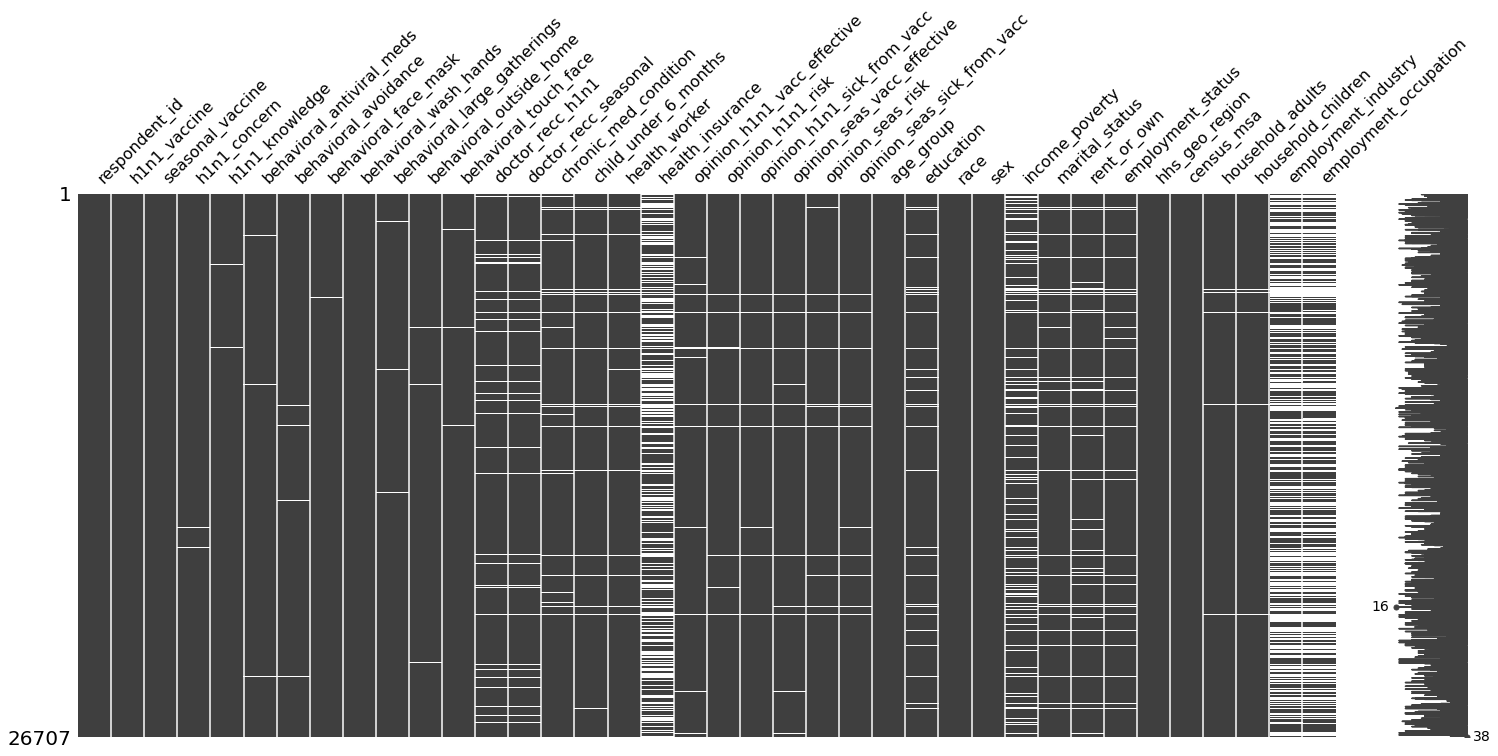

In [9]:
import missingno as msno
%matplotlib inline
msno.matrix(df.sample(26707))

- The employment_industry and employment_occupation columns seem to be highly correlated in terms of missing info (i.e. info that's missing in one column is missing in the other)
- The missing info in health_insurance doesn't seem to be correlated with anything

<AxesSubplot:>

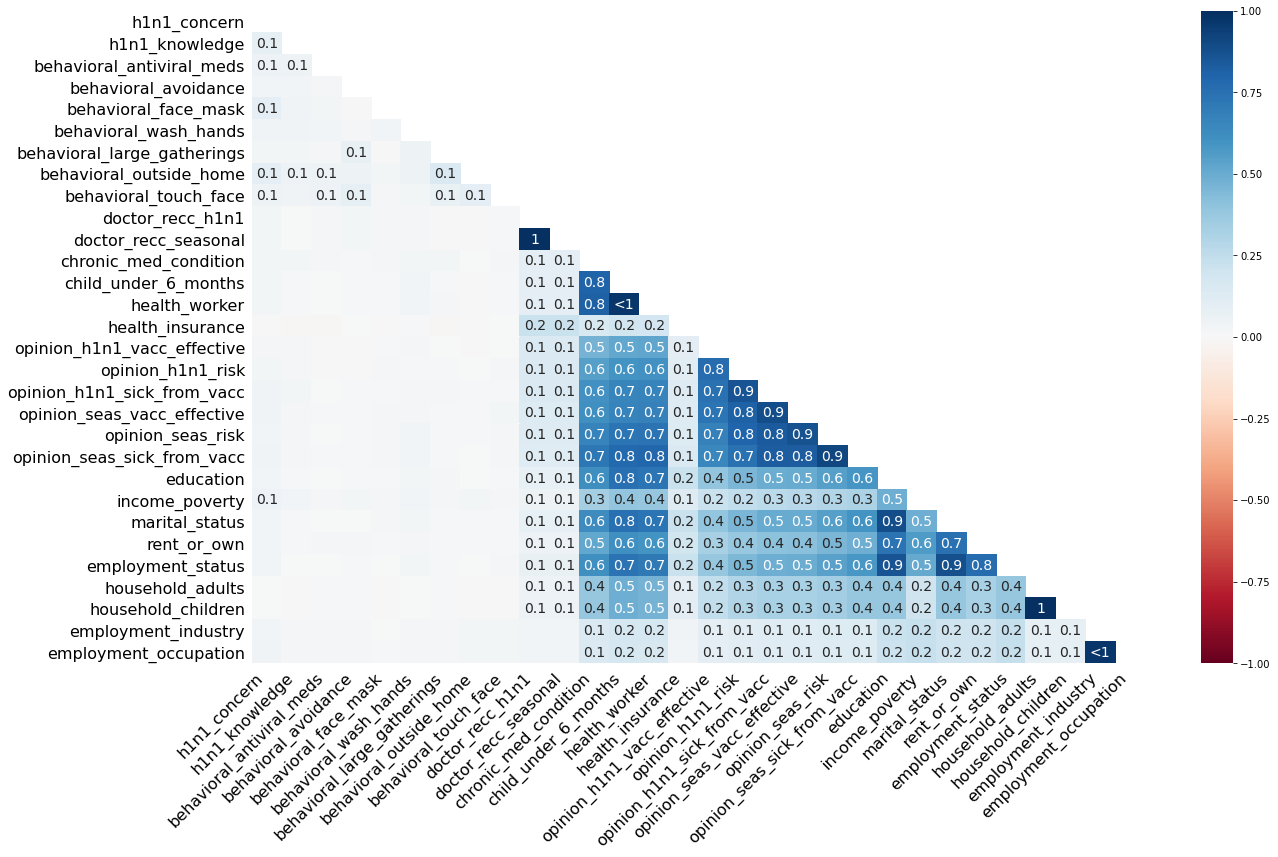

In [10]:
msno.heatmap(df)

<AxesSubplot:>

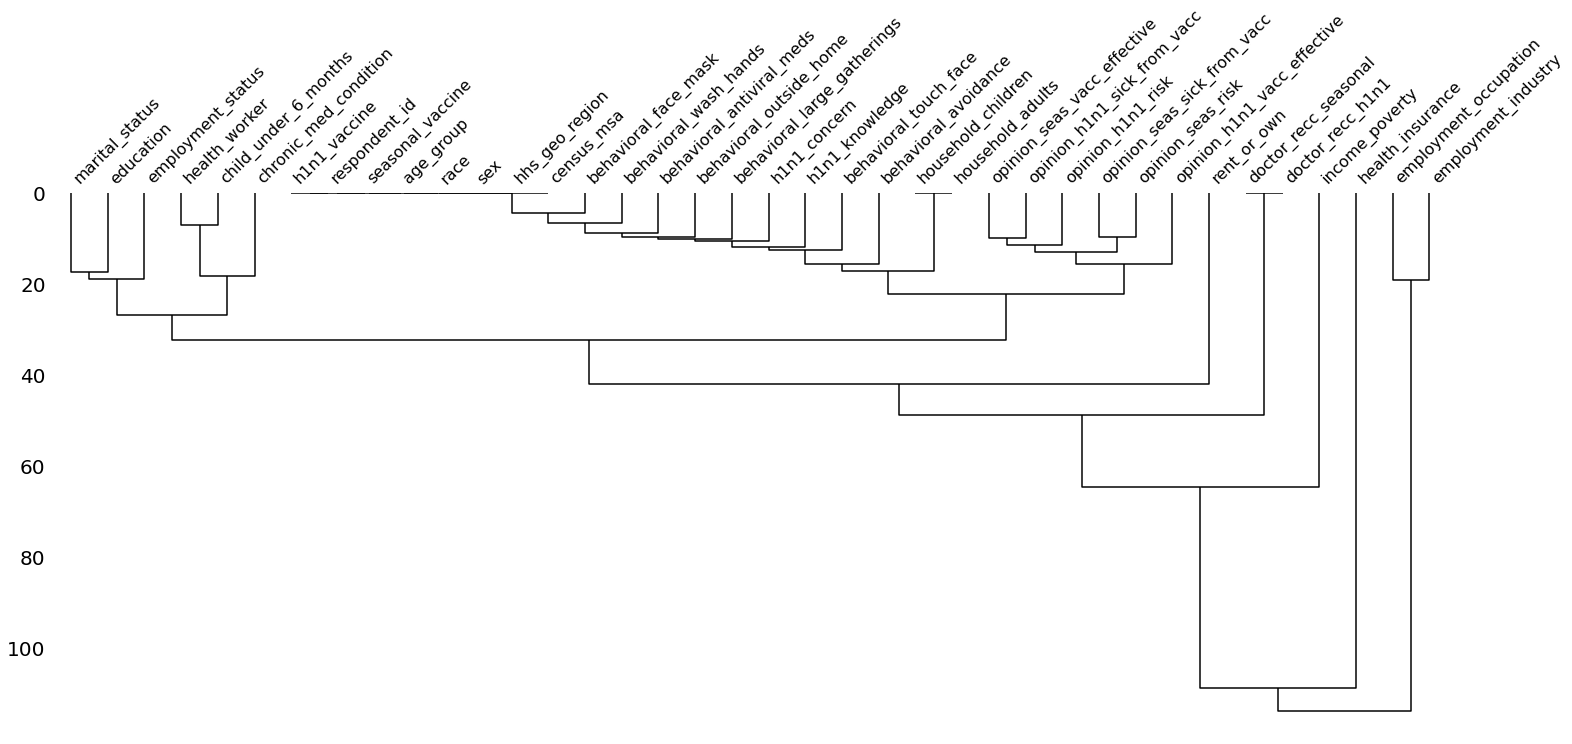

In [11]:
msno.dendrogram(df)

Visualising nullity by column:

<AxesSubplot:>

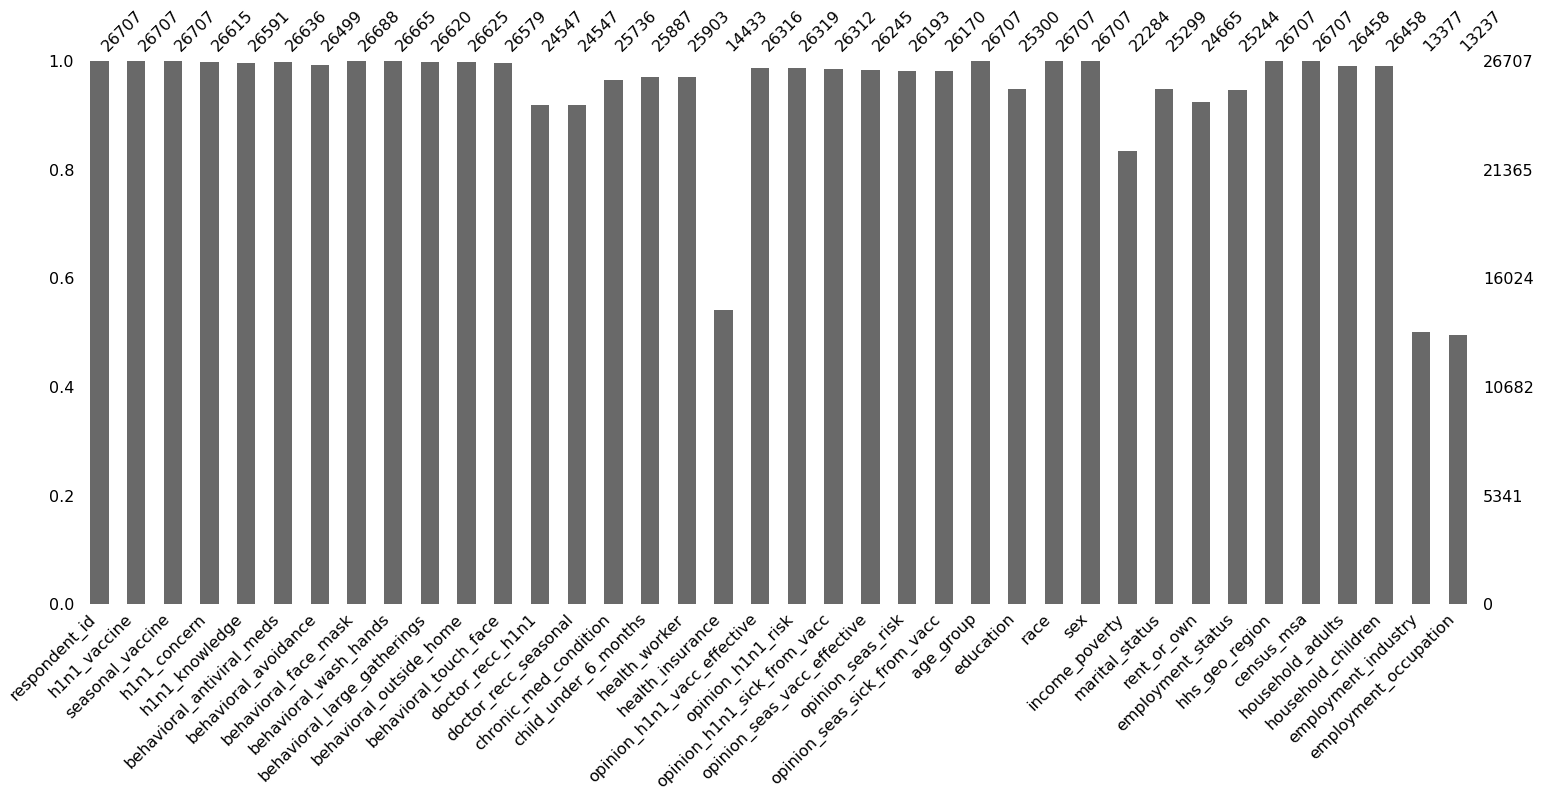

In [12]:
msno.bar(df.sample(26707))

## Initial strategy--drop some columns and then drop all rows with missing values

Dropping of features with too many missing values:

In [8]:
col_drop = ['health_insurance', 'employment_industry', 'employment_occupation', 'income_poverty', 'marital_status', 'employment_status']

df_initial = df.drop(col_drop, axis=1)

Also dropped the column 'respondent_id', because it will cause problems during 1-hot encoding:

In [9]:
#col_drop2 = ['index', 'respondent_id']
df_initial = df_initial.drop('respondent_id', axis=1)

Dropping of all rows with null values:

In [10]:
df_initial.dropna(inplace=True)

Check that all null values have been dropped:

In [11]:
df_initial.isnull().sum(axis = 0)

h1n1_vaccine                   0
seasonal_vaccine               0
h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
rent_or_own                    0
hhs_geo_region                 0
census_msa                     0
household_adults               0
household_

In [12]:
#the index is causing problems during 1-hot encoding
#df_initial.reset_index(inplace=True)

## Strategy 1: no imputation, leaving all missing values in

In [13]:
df = df.drop('respondent_id', axis=1)

In [14]:
df.isnull().sum(axis = 0)

h1n1_vaccine                       0
seasonal_vaccine                   0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
i

## Strategy 2: imputation with SimpleImputer, most frequent values

https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html  

We fill everything with the most frequent value that appeared in that column. 
Run on the whole dataset.

In [15]:
from sklearn.impute import SimpleImputer

# define imputer
imputer = SimpleImputer(strategy='most_frequent')

# fit on the dataset
imputer.fit(df)

# transform the dataset
df_mostfreq = pd.DataFrame(imputer.transform(df))

SimpleImputer gives a dataframe without column headings--here the headings are added back on

In [16]:
col_names = df.columns.values.tolist()

In [17]:
df_mostfreq.columns = col_names

Checking that all values have been dropped

In [18]:
df_mostfreq.isnull().sum(axis = 0)

h1n1_vaccine                   0
seasonal_vaccine               0
h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment

In [19]:
df_mostfreq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   h1n1_vaccine                 26707 non-null  object
 1   seasonal_vaccine             26707 non-null  object
 2   h1n1_concern                 26707 non-null  object
 3   h1n1_knowledge               26707 non-null  object
 4   behavioral_antiviral_meds    26707 non-null  object
 5   behavioral_avoidance         26707 non-null  object
 6   behavioral_face_mask         26707 non-null  object
 7   behavioral_wash_hands        26707 non-null  object
 8   behavioral_large_gatherings  26707 non-null  object
 9   behavioral_outside_home      26707 non-null  object
 10  behavioral_touch_face        26707 non-null  object
 11  doctor_recc_h1n1             26707 non-null  object
 12  doctor_recc_seasonal         26707 non-null  object
 13  chronic_med_condition        26

The SimpleImputer has converted all the columns to strings...so they should be changed to numeric (or at least the target variables should be converted)

In [20]:
df_mostfreq['h1n1_vaccine'] = pd.to_numeric(df_mostfreq['h1n1_vaccine'])
df_mostfreq['seasonal_vaccine'] = pd.to_numeric(df_mostfreq['seasonal_vaccine'])

In [21]:
df_mostfreq['health_insurance'].value_counts()

1.0    24971
0.0     1736
Name: health_insurance, dtype: int64

## Strategy X (tried without success): imputation with IterativeImputer, default settings (apart from initial_strategy = “most_frequent”)

CELLS CHANGED TO MARKDOWN TO AVOID INTERFERENCE IN THE REST OF NOTEBOOK; CHANGE TO CODE IF OUTPUT IS WANTED

https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer

initial_strategy = “most_frequent”; other parameters at default (Bayesian Ridge estimation used)

Other estimators: https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html

Dataframe split into X and Y before imputation, so the target variable isn't used in the imputation

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

y_strat3 = df[['h1n1_vaccine', 'seasonal_vaccine']].copy()

y_strat3 = y_strat3.to_numpy()

#NB: dropping the 'h1n1_vaccine' and 'seasonal_vaccine' columns
X_strat3 = df.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'])

The IterativeImputer seems to have an issue with string values, so data converted to numerical:

cleanup = {"age_group": {"18 - 34 Years": 1, "35 - 44 Years": 2, "45 - 54 Years": 3, "55 - 64 Years": 4,
                                  "65+ Years": 5},
            "education": {"< 12 Years": 1, "12 Years": 2, "Some College": 3, "College Graduate": 4},
            "race": {"White": 1, "Black": 2, "Hispanic": 3, "Other or Multiple": 4},
            "sex" : {"Female": 1, "Male": 2},
            "rent_or_own" : {"Own": 1, "Rent": 2},
            "hhs_geo_region" : {"lzgpxyit": 1, "fpwskwrf": 2, "qufhixun": 3, "bhuqouqj": 4, "oxchjgsf": 5, "kbazzjca": 6, "mlyzmhmf": 7, "atmpeygn": 8, "lrircsnp": 9, "dqpwygqj": 10},
            "census_msa" : {"MSA, Not Principle  City": 1, "MSA, Principle City": 2, "Non-MSA": 3},
            "income_poverty" : {"Below Poverty": 1, "<= $75,000, Above Poverty": 2, "> $75,000": 3},
            "employment_industry" : {"fcxhlnwr": 1, "wxleyezf": 2, "ldnlellj": 3, "pxcmvdjn": 4, "atmlpfrs": 5, "arjwrbjb": 6, "xicduogh": 7, "mfikgejo": 8, "vjjrobsf": 9,
                                    "rucpziij": 10, "xqicxuve": 11, "saaquncn": 12, "cfqqtusy": 13, "nduyfdeo": 14, "mcubkhph": 15, "wlfvacwt": 16, "dotnnunm": 17, "haxffmxo": 18, "msuufmds": 19, "phxvnwax": 20,
                                    "qnlwzans": 21},
           "employment_occupation" : {"xtkaffoo": 1, "mxkfnird": 2, "emcorrxb": 3, "cmhcxjea": 4, "xgwztkwe": 5, "hfxkjkmi": 6, "qxajmpny": 7, "xqwwgdyp": 8, "kldqjyjy": 9,
                                    "uqqtjvyb": 10, "tfqavkke": 11, "ukymxvdu": 12, "vlluhbov": 13, "oijqvulv": 14, "ccgxvspp": 15, "bxpfxfdn": 16, "haliazsg": 17, "rcertsgn": 18, "xzmlyyjv": 19, "dlvbwzss": 20,
                                    "hodpvpew": 21, "dcjcmpih": 22, "pvmttkik": 23},
           "marital_status" : {"Married": 1, "Not Married": 2},
           "employment_status" : {"Employed": 1, "Not in Labor Force": 2, "Unemployed": 3}
                                  }
X_strat3_num = X_strat3.replace(cleanup)

#X_strat3_num = pd.Categorical(X_strat3_num, ordered=True) this appraoch didn't work

Another way of converting from strings to numbers:

cat_cols = list(X_strat3.columns.values)

#function to encode the strin data, but keep the missing values
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()

def encode(data):
    #function to encode non-null data and replace it in the original data
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#create a for loop to iterate through each column in the data
for columns in cat_cols:
    encode(X_strat3[columns])

X_strat3.head()

#define imputer
it_imputer = IterativeImputer(initial_strategy='most_frequent')

#it_imputer.fit(X_strat3_num) #running imputer with numerical data, the imputation doesn't work--values falsely interpreted as "numbers"
X_iter = it_imputer.fit_transform(X_strat3) #running imputer with categorical data (strings)

IterativeImputer gives an array without column headings--here the headings are added back on and the array is converted back to a data frame:

col_names = X_strat3.columns.values.tolist()
X_iter = pd.DataFrame(X_iter, columns=col_names)

Unfortunately the IterativeImputer really doesn't seem to run with categorical data! Note the features that had string values but were converted to numerical encoding (e.g. employment_industry)--the missing values are imputed as continuous numbers! Giving up on this approach for now...

The comments in this post confirm this: https://krrai77.medium.com/using-fancyimpute-in-python-eadcffece782

X_iter.head()

## Strategy 3: imputation with KNNImputer

https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer

Dataframe split into X and Y before imputation, so the target variable isn't used in the imputation

In [41]:
y_strat3 = df[['h1n1_vaccine', 'seasonal_vaccine']].copy()

In [42]:
y_strat3 = y_strat3.to_numpy()

In [43]:
#NB: dropping the 'h1n1_vaccine' and 'seasonal_vaccine' columns
X_iter_knn = df.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'])

In [91]:
cleanup = {"age_group": {"18 - 34 Years": 1, "35 - 44 Years": 2, "45 - 54 Years": 3, "55 - 64 Years": 4,
                                  "65+ Years": 5},
            "education": {"< 12 Years": 1, "12 Years": 2, "Some College": 3, "College Graduate": 4},
            "race": {"White": 1, "Black": 2, "Hispanic": 3, "Other or Multiple": 4},
            "sex" : {"Female": 1, "Male": 2},
            "rent_or_own" : {"Own": 1, "Rent": 2},
            "hhs_geo_region" : {"lzgpxyit": 1, "fpwskwrf": 2, "qufhixun": 3, "bhuqouqj": 4, "oxchjgsf": 5, "kbazzjca": 6, "mlyzmhmf": 7, "atmpeygn": 8, "lrircsnp": 9, "dqpwygqj": 10},
            "census_msa" : {"MSA, Not Principle  City": 1, "MSA, Principle City": 2, "Non-MSA": 3},
            "income_poverty" : {"Below Poverty": 1, "<= $75,000, Above Poverty": 2, "> $75,000": 3},
            "employment_industry" : {"fcxhlnwr": 1, "wxleyezf": 2, "ldnlellj": 3, "pxcmvdjn": 4, "atmlpfrs": 5, "arjwrbjb": 6, "xicduogh": 7, "mfikgejo": 8, "vjjrobsf": 9,
                                    "rucpziij": 10, "xqicxuve": 11, "saaquncn": 12, "cfqqtusy": 13, "nduyfdeo": 14, "mcubkhph": 15, "wlfvacwt": 16, "dotnnunm": 17, "haxffmxo": 18, "msuufmds": 19, "phxvnwax": 20,
                                    "qnlwzans": 21},
           "employment_occupation" : {"xtkaffoo": 1, "mxkfnird": 2, "emcorrxb": 3, "cmhcxjea": 4, "xgwztkwe": 5, "hfxkjkmi": 6, "qxajmpny": 7, "xqwwgdyp": 8, "kldqjyjy": 9,
                                    "uqqtjvyb": 10, "tfqavkke": 11, "ukymxvdu": 12, "vlluhbov": 13, "oijqvulv": 14, "ccgxvspp": 15, "bxpfxfdn": 16, "haliazsg": 17, "rcertsgn": 18, "xzmlyyjv": 19, "dlvbwzss": 20,
                                    "hodpvpew": 21, "dcjcmpih": 22, "pvmttkik": 23},
           "marital_status" : {"Married": 1, "Not Married": 2},
           "employment_status" : {"Employed": 1, "Not in Labor Force": 2, "Unemployed": 3}
                                  }
X_iter_knn_num = X_iter_knn.replace(cleanup)

In [133]:
#function to encode the strin data, but keep the missing values
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()

cat_cols = list(X_iter_knn.columns.values)

def encode(data):
    #function to encode non-null data and replace it in the original data
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#create a for loop to iterate through each column in the data
for columns in cat_cols:
    encode(X_iter_knn[columns])

In [136]:
X_iter_knn_num = X_iter_knn_num.astype('Int64')

In [138]:
X_iter_knn_num.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,educationmap,employment_occupationmap
0,1,0,0,0,0,0,0,1,1,0,...,1,2,5,3,0,0,<NA>,<NA>,1,<NA>
1,3,2,0,1,0,1,0,1,1,0,...,2,1,4,1,0,0,4,5,2,5
2,1,1,0,1,0,0,0,0,0,<NA>,...,1,1,3,1,2,0,10,1,4,1
3,1,1,0,1,0,1,1,0,0,0,...,2,2,9,2,0,0,<NA>,<NA>,2,<NA>
4,2,1,0,1,0,1,1,0,1,0,...,1,1,3,1,1,0,2,3,3,3


In [140]:
X_iter_knn_num['education'].value_counts()

4    10097
3     7043
2     5797
1     2363
Name: education, dtype: Int64

In [141]:
from sklearn.impute import KNNImputer

#define imputer
knn_imputer = KNNImputer(n_neighbors=3)

# fit and transform on the dataset
X_strat3 = knn_imputer.fit_transform(X_iter_knn_num)

In [142]:
col_names = X_iter_knn.columns.values.tolist()
X_strat3 = pd.DataFrame(X_strat3, columns=col_names)

In [143]:
X_strat3.isnull().sum(axis = 0)

h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_region                 0
census_msa

Values are imputed, but the numerical categories are treated as continuous--therefore, some of the imputed features are continuous numbers that fall in between the categories (e.g. 7.6666). As a work-around, all the values in the dataframe were rounded to the nearest whole number.

In [145]:
X_strat3 = X_strat3.round()

In [146]:
X_strat3.tail()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,educationmap,employment_occupationmap
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,2.0,3.0,3.0,0.0,0.0,5.0,8.0,3.0,8.0
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,2.0,1.0,1.0,2.0,1.0,0.0,1.0,4.0,4.0,4.0
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,2.0,1.0,1.0,0.0,0.0,4.0,4.0,3.0,4.0
26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,9.0,3.0,1.0,0.0,1.0,17.0,3.0,17.0
26706,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,7.0,2.0,1.0,0.0,11.0,11.0,3.0,11.0


## Strategy 4:  imputation with IterativeImputer, default settings (apart from initial_strategy = “most_frequent”)

https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer

initial_strategy = “most_frequent”; other parameters at default (Bayesian Ridge estimation used)

Other estimators: https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html

Dataframe split into X and Y before imputation, so the target variable isn't used in the imputation

In [240]:
y_strat4 = df[['h1n1_vaccine', 'seasonal_vaccine']].copy()

In [241]:
y_strat4 = y_strat4.to_numpy()

In [242]:
#NB: dropping the 'h1n1_vaccine' and 'seasonal_vaccine' columns
X_iter = df.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'])

In [243]:
cleanup = {"age_group": {"18 - 34 Years": 1, "35 - 44 Years": 2, "45 - 54 Years": 3, "55 - 64 Years": 4,
                                  "65+ Years": 5},
            "education": {"< 12 Years": 1, "12 Years": 2, "Some College": 3, "College Graduate": 4},
            "race": {"White": 1, "Black": 2, "Hispanic": 3, "Other or Multiple": 4},
            "sex" : {"Female": 1, "Male": 2},
            "rent_or_own" : {"Own": 1, "Rent": 2},
            "hhs_geo_region" : {"lzgpxyit": 1, "fpwskwrf": 2, "qufhixun": 3, "bhuqouqj": 4, "oxchjgsf": 5, "kbazzjca": 6, "mlyzmhmf": 7, "atmpeygn": 8, "lrircsnp": 9, "dqpwygqj": 10},
            "census_msa" : {"MSA, Not Principle  City": 1, "MSA, Principle City": 2, "Non-MSA": 3},
            "income_poverty" : {"Below Poverty": 1, "<= $75,000, Above Poverty": 2, "> $75,000": 3},
            "employment_industry" : {"fcxhlnwr": 1, "wxleyezf": 2, "ldnlellj": 3, "pxcmvdjn": 4, "atmlpfrs": 5, "arjwrbjb": 6, "xicduogh": 7, "mfikgejo": 8, "vjjrobsf": 9,
                                    "rucpziij": 10, "xqicxuve": 11, "saaquncn": 12, "cfqqtusy": 13, "nduyfdeo": 14, "mcubkhph": 15, "wlfvacwt": 16, "dotnnunm": 17, "haxffmxo": 18, "msuufmds": 19, "phxvnwax": 20,
                                    "qnlwzans": 21},
           "employment_occupation" : {"xtkaffoo": 1, "mxkfnird": 2, "emcorrxb": 3, "cmhcxjea": 4, "xgwztkwe": 5, "hfxkjkmi": 6, "qxajmpny": 7, "xqwwgdyp": 8, "kldqjyjy": 9,
                                    "uqqtjvyb": 10, "tfqavkke": 11, "ukymxvdu": 12, "vlluhbov": 13, "oijqvulv": 14, "ccgxvspp": 15, "bxpfxfdn": 16, "haliazsg": 17, "rcertsgn": 18, "xzmlyyjv": 19, "dlvbwzss": 20,
                                    "hodpvpew": 21, "dcjcmpih": 22, "pvmttkik": 23},
           "marital_status" : {"Married": 1, "Not Married": 2},
           "employment_status" : {"Employed": 1, "Not in Labor Force": 2, "Unemployed": 3}
                                  }
X_iter = X_iter.replace(cleanup)

In [244]:
X_iter = X_iter.astype('Int64')

In [245]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#define imputer
iter_imputer = IterativeImputer(initial_strategy='most_frequent')

# fit and transform on the dataset
X_strat4 = iter_imputer.fit_transform(X_iter)

In [246]:
col_names = X_iter.columns.values.tolist()
X_strat4 = pd.DataFrame(X_strat4, columns=col_names)

In [247]:
X_strat4.isnull().sum(axis = 0)

h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_region                 0
census_msa

Values are imputed, but the numerical categories are treated as continuous--therefore, some of the imputed features are continuous numbers that fall in between the categories (e.g. 7.6666). As a work-around, all the values in the dataframe were rounded to the nearest whole number.

In [248]:
X_strat4 = X_strat4.round()

One value in X_strat4['marital_status'] got rounded down to 0 and is causing problems--row with this value was deleted

In [225]:
X_strat4['marital_status'].value_counts()

1.0    14342
2.0    12364
0.0        1
Name: marital_status, dtype: int64

In [226]:
X_strat4[X_strat4.marital_status == 0].index

Int64Index([18121], dtype='int64')

In [228]:
y_strat4[18121]

array([0, 0])

In [251]:
y_strat4 = np.delete(y_strat4, 18121, axis = 0)

In [253]:
X_strat4 = X_strat4[X_strat4.marital_status != 0]

In [254]:
X_strat4.shape

(26706, 35)

In [255]:
y_strat4.shape

(26706, 2)

## Strategy 5:  imputation with IterativeImputer, Decision Tree regressor (initial_strategy = “most_frequent”)

https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer

initial_strategy = “most_frequent”; other parameters at default (Bayesian Ridge estimation used)

Other estimators: https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html

Dataframe split into X and Y before imputation, so the target variable isn't used in the imputation

In [271]:
y_strat5 = df[['h1n1_vaccine', 'seasonal_vaccine']].copy()

In [272]:
y_strat5 = y_strat5.to_numpy()

In [273]:
#NB: dropping the 'h1n1_vaccine' and 'seasonal_vaccine' columns
X_iter_DT = df.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'])

In [274]:
cleanup = {"age_group": {"18 - 34 Years": 1, "35 - 44 Years": 2, "45 - 54 Years": 3, "55 - 64 Years": 4,
                                  "65+ Years": 5},
            "education": {"< 12 Years": 1, "12 Years": 2, "Some College": 3, "College Graduate": 4},
            "race": {"White": 1, "Black": 2, "Hispanic": 3, "Other or Multiple": 4},
            "sex" : {"Female": 1, "Male": 2},
            "rent_or_own" : {"Own": 1, "Rent": 2},
            "hhs_geo_region" : {"lzgpxyit": 1, "fpwskwrf": 2, "qufhixun": 3, "bhuqouqj": 4, "oxchjgsf": 5, "kbazzjca": 6, "mlyzmhmf": 7, "atmpeygn": 8, "lrircsnp": 9, "dqpwygqj": 10},
            "census_msa" : {"MSA, Not Principle  City": 1, "MSA, Principle City": 2, "Non-MSA": 3},
            "income_poverty" : {"Below Poverty": 1, "<= $75,000, Above Poverty": 2, "> $75,000": 3},
            "employment_industry" : {"fcxhlnwr": 1, "wxleyezf": 2, "ldnlellj": 3, "pxcmvdjn": 4, "atmlpfrs": 5, "arjwrbjb": 6, "xicduogh": 7, "mfikgejo": 8, "vjjrobsf": 9,
                                    "rucpziij": 10, "xqicxuve": 11, "saaquncn": 12, "cfqqtusy": 13, "nduyfdeo": 14, "mcubkhph": 15, "wlfvacwt": 16, "dotnnunm": 17, "haxffmxo": 18, "msuufmds": 19, "phxvnwax": 20,
                                    "qnlwzans": 21},
           "employment_occupation" : {"xtkaffoo": 1, "mxkfnird": 2, "emcorrxb": 3, "cmhcxjea": 4, "xgwztkwe": 5, "hfxkjkmi": 6, "qxajmpny": 7, "xqwwgdyp": 8, "kldqjyjy": 9,
                                    "uqqtjvyb": 10, "tfqavkke": 11, "ukymxvdu": 12, "vlluhbov": 13, "oijqvulv": 14, "ccgxvspp": 15, "bxpfxfdn": 16, "haliazsg": 17, "rcertsgn": 18, "xzmlyyjv": 19, "dlvbwzss": 20,
                                    "hodpvpew": 21, "dcjcmpih": 22, "pvmttkik": 23},
           "marital_status" : {"Married": 1, "Not Married": 2},
           "employment_status" : {"Employed": 1, "Not in Labor Force": 2, "Unemployed": 3}
                                  }
X_iter_DT = X_iter_DT.replace(cleanup)

In [275]:
X_iter_DT = X_iter_DT.astype('Int64')

In [277]:
from sklearn.tree import DecisionTreeRegressor

#define imputer
iter_imputer_DT = IterativeImputer(estimator = DecisionTreeRegressor(), initial_strategy='most_frequent')

# fit and transform on the dataset
X_strat5 = iter_imputer_DT.fit_transform(X_iter_DT)

In [278]:
col_names = X_iter_DT.columns.values.tolist()
X_strat5 = pd.DataFrame(X_strat5, columns=col_names)

In [279]:
X_strat5.isnull().sum(axis = 0)

h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_region                 0
census_msa

Values are imputed, but the numerical categories are treated as continuous--therefore, some of the imputed features are continuous numbers that fall in between the categories (e.g. 7.6666). As a work-around, all the values in the dataframe were rounded to the nearest whole number.

In [280]:
X_strat5 = X_strat5.round()

---

These parts need to be adjusted for each imputation strategy

## Initial strategy

### Setting up variables

In [ ]:
cat_features = list(df_initial.columns)

Removal of target variables from cat_features list:

In [ ]:
cat_features.remove('h1n1_vaccine')

In [ ]:
cat_features.remove('seasonal_vaccine')

Rename the features and target to 'X' and 'y', to make the test-train split easier (adjust for each dataframe, because the number of rows in the target will be different, depending on imputation strategy):

In [ ]:
y_initial = df_initial[['h1n1_vaccine', 'seasonal_vaccine']].copy()

In [ ]:
y_initial = y_initial.to_numpy()

In [ ]:
#NB: dropping the 'h1n1_vaccine' and 'seasonal_vaccine' columns
X_initial = df_initial.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'])

### Setting up pipeline  

Doesn't need modifying, but needs to be run for each imputation strategy

In [ ]:
# Pipeline for categorical features
#CHECK HERE--ARE WE DROPPING THE FIRST COLUMN TO PREVENT MULTICOLINEARITY?
cat_pipeline = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown='error', drop='first'))
])

In [ ]:
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cat_features)
])

In [ ]:
estimators = MultiOutputClassifier(
    estimator=LogisticRegression()
)

In [ ]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

### Train-test split

Names need to be modified

In [ ]:
X_train_init, X_test_init, y_train_init, y_test_init = train_test_split(X_initial, y_initial, stratify = y_initial, test_size=0.2, random_state=RSEED)

In [ ]:
print('X_train_init shape:', X_train_init.shape)
print('X_test_init shape:', X_test_init.shape)
print('y_train_init shape:', y_train_init.shape)
print('y_test_init shape:', y_test_init.shape)

In [ ]:
full_pipeline.fit(X_train_init, y_train_init)

In [ ]:
#getting predictions from train data
preds_train_init = full_pipeline.predict(X_train_init)

In [ ]:
#getting predictions from test data
preds_test_init = full_pipeline.predict(X_test_init)


### Model evaluation

In [ ]:
# Evaluation Metrices for H1N1 Vaccines--train data
print("Accuracy: {:.2f}".format(accuracy_score(y_train_init[:, 0], preds_train_init[:, 0])))
print("Recall: {:.2f}".format(recall_score(y_train_init[:, 0], preds_train_init[:, 0])))
print("Precision: {:.2f}".format(precision_score(y_train_init[:, 0], preds_train_init[:, 0])))
print("F1: {:.2f}".format(f1_score(y_train_init[:, 0], preds_train_init[:, 0])))
print("ROC: {:.2f}".format(roc_auc_score(y_train_init[:, 0], preds_train_init[:, 0])))

In [ ]:
# Evaluation Metrices for H1N1 Vaccines--test data
print("Accuracy: {:.2f}".format(accuracy_score(y_test_init[:, 0], preds_test_init[:, 0])))
print("Recall: {:.2f}".format(recall_score(y_test_init[:, 0], preds_test_init[:, 0])))
print("Precision: {:.2f}".format(precision_score(y_test_init[:, 0], preds_test_init[:, 0])))
print("F1: {:.2f}".format(f1_score(y_test_init[:, 0], preds_test_init[:, 0])))
print("ROC: {:.2f}".format(roc_auc_score(y_test_init[:, 0], preds_test_init[:, 0])))

In [ ]:
# Evaluation Metrices for Seasonal Flu Vaccines--train data
print("Accuracy: {:.2f}".format(accuracy_score(y_train_init[:, 1], preds_train_init[:, 1])))
print("Recall: {:.2f}".format(recall_score(y_train_init[:, 1], preds_train_init[:, 1])))
print("Precision: {:.2f}".format(precision_score(y_train_init[:, 1], preds_train_init[:, 1])))
print("F1: {:.2f}".format(f1_score(y_train_init[:, 1], preds_train_init[:, 1])))
print("ROC: {:.2f}".format(roc_auc_score(y_train_init[:, 1], preds_train_init[:, 1])))

In [ ]:
# Evaluation Metrices for Seasonal Flu Vaccines--test data
print("Accuracy: {:.2f}".format(accuracy_score(y_test_init[:, 1], preds_test_init[:, 1])))
print("Recall: {:.2f}".format(recall_score(y_test_init[:, 1], preds_test_init[:, 1])))
print("Precision: {:.2f}".format(precision_score(y_test_init[:, 1], preds_test_init[:, 1])))
print("F1: {:.2f}".format(f1_score(y_test_init[:, 1], preds_test_init[:, 1])))
print("ROC: {:.2f}".format(roc_auc_score(y_test_init[:, 1], preds_test_init[:, 1])))

---

## Strategy 1--no imputation

### Setting up variables

In [ ]:
cat_features = list(df.columns)

Removal of target variables from cat_features list:

In [ ]:
cat_features.remove('h1n1_vaccine')

In [ ]:
cat_features.remove('seasonal_vaccine')

Rename the features and target to 'X' and 'y', to make the test-train split easier (adjust for each dataframe, because the number of rows in the target will be different, depending on imputation strategy):

In [ ]:
y_strat1 = df[['h1n1_vaccine', 'seasonal_vaccine']].copy()

In [ ]:
y_strat1 = y_strat1.to_numpy()

In [ ]:
#NB: dropping the 'h1n1_vaccine' and 'seasonal_vaccine' columns
X_strat1 = df.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'])

### Setting up pipeline  

Doesn't need modifying, but needs to be run for each imputation strategy

In [ ]:
# Pipeline for categorical features
#CHECK HERE--ARE WE DROPPING THE FIRST COLUMN TO PREVENT MULTICOLINEARITY?
cat_pipeline = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown='error', drop='first'))
])

In [ ]:
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cat_features)
])

In [ ]:
estimators = MultiOutputClassifier(
    estimator=LogisticRegression()
)

In [ ]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

### Train-test split

Names need to be modified

In [ ]:
X_train_strat1, X_test_strat1, y_train_strat1, y_test_strat1 = train_test_split(X_strat1, y_strat1, stratify = y_strat1, test_size=0.2, random_state=RSEED)

In [ ]:
print('X_train_strat1 shape:', X_train_strat1.shape)
print('X_test_strat1 shape:', X_test_strat1.shape)
print('y_train_strat1 shape:', y_train_strat1.shape)
print('y_test_strat1 shape:', y_test_strat1.shape)

In [ ]:
full_pipeline.fit(X_train_strat1, y_train_strat1)

In [ ]:
#getting predictions from train data
preds_train_strat1 = full_pipeline.predict(X_train_strat1)

In [ ]:
#getting predictions from test data
preds_test_strat1 = full_pipeline.predict(X_test_strat1)


### Model evaluation

In [ ]:
# Evaluation Metrices for H1N1 Vaccines--train data
print("Accuracy: {:.2f}".format(accuracy_score(y_train_strat1[:, 0], preds_train_strat1[:, 0])))
print("Recall: {:.2f}".format(recall_score(y_train_strat1[:, 0], preds_train_strat1[:, 0])))
print("Precision: {:.2f}".format(precision_score(y_train_strat1[:, 0], preds_train_strat1[:, 0])))
print("F1: {:.2f}".format(f1_score(y_train_strat1[:, 0], preds_train_strat1[:, 0])))
print("ROC: {:.2f}".format(roc_auc_score(y_train_strat1[:, 0], preds_train_strat1[:, 0])))

In [ ]:
# Evaluation Metrices for H1N1 Vaccines--test data
print("Accuracy: {:.2f}".format(accuracy_score(y_test_strat1[:, 0], preds_test_strat1[:, 0])))
print("Recall: {:.2f}".format(recall_score(y_test_strat1[:, 0], preds_test_strat1[:, 0])))
print("Precision: {:.2f}".format(precision_score(y_test_strat1[:, 0], preds_test_strat1[:, 0])))
print("F1: {:.2f}".format(f1_score(y_test_strat1[:, 0], preds_test_strat1[:, 0])))
print("ROC: {:.2f}".format(roc_auc_score(y_test_strat1[:, 0], preds_test_strat1[:, 0])))

In [ ]:
# Evaluation Metrices for Seasonal Flu Vaccines--train data
print("Accuracy: {:.2f}".format(accuracy_score(y_train_strat1[:, 1], preds_train_strat1[:, 1])))
print("Recall: {:.2f}".format(recall_score(y_train_strat1[:, 1], preds_train_strat1[:, 1])))
print("Precision: {:.2f}".format(precision_score(y_train_strat1[:, 1], preds_train_strat1[:, 1])))
print("F1: {:.2f}".format(f1_score(y_train_strat1[:, 1], preds_train_strat1[:, 1])))
print("ROC: {:.2f}".format(roc_auc_score(y_train_strat1[:, 1], preds_train_strat1[:, 1])))

In [ ]:
# Evaluation Metrices for Seasonal Flu Vaccines--test data
print("Accuracy: {:.2f}".format(accuracy_score(y_test_strat1[:, 1], preds_test_strat1[:, 1])))
print("Recall: {:.2f}".format(recall_score(y_test_strat1[:, 1], preds_test_strat1[:, 1])))
print("Precision: {:.2f}".format(precision_score(y_test_strat1[:, 1], preds_test_strat1[:, 1])))
print("F1: {:.2f}".format(f1_score(y_test_strat1[:, 1], preds_test_strat1[:, 1])))
print("ROC: {:.2f}".format(roc_auc_score(y_test_strat1[:, 1], preds_test_strat1[:, 1])))

---

## Strategy 2: imputation with SimpleImputer, most frequent values

### Setting up variables

In [ ]:
cat_features = list(df_mostfreq.columns)

Removal of target variables from cat_features list:

In [ ]:
cat_features.remove('h1n1_vaccine')

In [ ]:
cat_features.remove('seasonal_vaccine')

Rename the features and target to 'X' and 'y', to make the test-train split easier (adjust for each dataframe, because the number of rows in the target will be different, depending on imputation strategy):

In [ ]:
y_strat2 = df_mostfreq[['h1n1_vaccine', 'seasonal_vaccine']].copy()

In [ ]:
y_strat2 = y_strat2.to_numpy()

In [ ]:
#NB: dropping the 'h1n1_vaccine' and 'seasonal_vaccine' columns
X_strat2 = df_mostfreq.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'])

### Setting up pipeline  

Doesn't need modifying, but needs to be run for each imputation strategy

In [ ]:
# Pipeline for categorical features
#CHECK HERE--ARE WE DROPPING THE FIRST COLUMN TO PREVENT MULTICOLINEARITY?
cat_pipeline = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown='error', drop='first'))
])

In [ ]:
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cat_features)
])

In [ ]:
estimators = MultiOutputClassifier(
    estimator=LogisticRegression()
)

In [ ]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

### Train-test split

Names need to be modified

In [ ]:
X_train_strat2, X_test_strat2, y_train_strat2, y_test_strat2 = train_test_split(X_strat2, y_strat2, stratify = y_strat2, test_size=0.2, random_state=RSEED)

In [ ]:
print('X_train_strat2 shape:', X_train_strat2.shape)
print('X_test_strat2 shape:', X_test_strat2.shape)
print('y_train_strat2 shape:', y_train_strat2.shape)
print('y_test_strat2 shape:', y_test_strat2.shape)

In [ ]:
full_pipeline.fit(X_train_strat2, y_train_strat2)

In [ ]:
#getting predictions from train data
preds_train_strat2 = full_pipeline.predict(X_train_strat2)

In [ ]:
#getting predictions from test data
preds_test_strat2 = full_pipeline.predict(X_test_strat2)

### Model evaluation

In [ ]:
# Evaluation Metrices for H1N1 Vaccines--train data
print("Accuracy: {:.2f}".format(accuracy_score(y_train_strat2[:, 0], preds_train_strat2[:, 0])))
print("Recall: {:.2f}".format(recall_score(y_train_strat2[:, 0], preds_train_strat2[:, 0])))
print("Precision: {:.2f}".format(precision_score(y_train_strat2[:, 0], preds_train_strat2[:, 0])))
print("F1: {:.2f}".format(f1_score(y_train_strat2[:, 0], preds_train_strat2[:, 0])))
print("ROC: {:.2f}".format(roc_auc_score(y_train_strat2[:, 0], preds_train_strat2[:, 0])))

In [ ]:
# Evaluation Metrices for H1N1 Vaccines--test data
print("Accuracy: {:.2f}".format(accuracy_score(y_test_strat2[:, 0], preds_test_strat2[:, 0])))
print("Recall: {:.2f}".format(recall_score(y_test_strat2[:, 0], preds_test_strat2[:, 0])))
print("Precision: {:.2f}".format(precision_score(y_test_strat2[:, 0], preds_test_strat2[:, 0])))
print("F1: {:.2f}".format(f1_score(y_test_strat2[:, 0], preds_test_strat2[:, 0])))
print("ROC: {:.2f}".format(roc_auc_score(y_test_strat2[:, 0], preds_test_strat2[:, 0])))

In [ ]:
# Evaluation Metrices for Seasonal Flu Vaccines--train data
print("Accuracy: {:.2f}".format(accuracy_score(y_train_strat2[:, 1], preds_train_strat2[:, 1])))
print("Recall: {:.2f}".format(recall_score(y_train_strat2[:, 1], preds_train_strat2[:, 1])))
print("Precision: {:.2f}".format(precision_score(y_train_strat2[:, 1], preds_train_strat2[:, 1])))
print("F1: {:.2f}".format(f1_score(y_train_strat2[:, 1], preds_train_strat2[:, 1])))
print("ROC: {:.2f}".format(roc_auc_score(y_train_strat2[:, 1], preds_train_strat2[:, 1])))

In [ ]:
# Evaluation Metrices for Seasonal Flu Vaccines--test data
print("Accuracy: {:.2f}".format(accuracy_score(y_test_strat2[:, 1], preds_test_strat2[:, 1])))
print("Recall: {:.2f}".format(recall_score(y_test_strat2[:, 1], preds_test_strat2[:, 1])))
print("Precision: {:.2f}".format(precision_score(y_test_strat2[:, 1], preds_test_strat2[:, 1])))
print("F1: {:.2f}".format(f1_score(y_test_strat2[:, 1], preds_test_strat2[:, 1])))
print("ROC: {:.2f}".format(roc_auc_score(y_test_strat2[:, 1], preds_test_strat2[:, 1])))

## Strategy 3: imputation with KNNImputer

### Setting up pipeline  

Doesn't need modifying, but needs to be run for each imputation strategy

### Setting up variables

In [147]:
cat_features = list(X_strat3.columns)

In [148]:
# Pipeline for categorical features
#CHECK HERE--ARE WE DROPPING THE FIRST COLUMN TO PREVENT MULTICOLINEARITY?
cat_pipeline = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown='error', drop='first'))
])

In [149]:
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cat_features)
])

In [150]:
estimators = MultiOutputClassifier(
    estimator=LogisticRegression()
)

In [151]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

### Train-test split

Names need to be modified

In [152]:
X_train_strat3, X_test_strat3, y_train_strat3, y_test_strat3 = train_test_split(X_strat3, y_strat3, stratify = y_strat3, test_size=0.2, random_state=RSEED)

In [153]:
print('X_train_strat3 shape:', X_train_strat3.shape)
print('X_test_strat3 shape:', X_test_strat3.shape)
print('y_train_strat3 shape:', y_train_strat3.shape)
print('y_test_strat3 shape:', y_test_strat3.shape)

X_train_strat3 shape: (21365, 37)
X_test_strat3 shape: (5342, 37)
y_train_strat3 shape: (21365, 2)
y_test_strat3 shape: (5342, 2)


In [154]:
full_pipeline.fit(X_train_strat3, y_train_strat3)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor

In [155]:
#getting predictions from train data
preds_train_strat3 = full_pipeline.predict(X_train_strat3)

In [156]:
#getting predictions from test data
preds_test_strat3 = full_pipeline.predict(X_test_strat3)

### Model evaluation

In [157]:
# Evaluation Metrices for H1N1 Vaccines--train data
print("Accuracy: {:.2f}".format(accuracy_score(y_train_strat3[:, 0], preds_train_strat3[:, 0])))
print("Recall: {:.2f}".format(recall_score(y_train_strat3[:, 0], preds_train_strat3[:, 0])))
print("Precision: {:.2f}".format(precision_score(y_train_strat3[:, 0], preds_train_strat3[:, 0])))
print("F1: {:.2f}".format(f1_score(y_train_strat3[:, 0], preds_train_strat3[:, 0])))
print("ROC: {:.2f}".format(roc_auc_score(y_train_strat3[:, 0], preds_train_strat3[:, 0])))

Accuracy: 0.83
Recall: 0.42
Precision: 0.68
F1: 0.52
ROC: 0.68


In [158]:
# Evaluation Metrices for H1N1 Vaccines--test data
print("Accuracy: {:.2f}".format(accuracy_score(y_test_strat3[:, 0], preds_test_strat3[:, 0])))
print("Recall: {:.2f}".format(recall_score(y_test_strat3[:, 0], preds_test_strat3[:, 0])))
print("Precision: {:.2f}".format(precision_score(y_test_strat3[:, 0], preds_test_strat3[:, 0])))
print("F1: {:.2f}".format(f1_score(y_test_strat3[:, 0], preds_test_strat3[:, 0])))
print("ROC: {:.2f}".format(roc_auc_score(y_test_strat3[:, 0], preds_test_strat3[:, 0])))

Accuracy: 0.83
Recall: 0.42
Precision: 0.68
F1: 0.52
ROC: 0.68


In [159]:
# Evaluation Metrices for Seasonal Flu Vaccines--train data
print("Accuracy: {:.2f}".format(accuracy_score(y_train_strat3[:, 1], preds_train_strat3[:, 1])))
print("Recall: {:.2f}".format(recall_score(y_train_strat3[:, 1], preds_train_strat3[:, 1])))
print("Precision: {:.2f}".format(precision_score(y_train_strat3[:, 1], preds_train_strat3[:, 1])))
print("F1: {:.2f}".format(f1_score(y_train_strat3[:, 1], preds_train_strat3[:, 1])))
print("ROC: {:.2f}".format(roc_auc_score(y_train_strat3[:, 1], preds_train_strat3[:, 1])))

Accuracy: 0.78
Recall: 0.75
Precision: 0.78
F1: 0.76
ROC: 0.78


In [160]:
# Evaluation Metrices for Seasonal Flu Vaccines--test data
print("Accuracy: {:.2f}".format(accuracy_score(y_test_strat3[:, 1], preds_test_strat3[:, 1])))
print("Recall: {:.2f}".format(recall_score(y_test_strat3[:, 1], preds_test_strat3[:, 1])))
print("Precision: {:.2f}".format(precision_score(y_test_strat3[:, 1], preds_test_strat3[:, 1])))
print("F1: {:.2f}".format(f1_score(y_test_strat3[:, 1], preds_test_strat3[:, 1])))
print("ROC: {:.2f}".format(roc_auc_score(y_test_strat3[:, 1], preds_test_strat3[:, 1])))

Accuracy: 0.78
Recall: 0.75
Precision: 0.77
F1: 0.76
ROC: 0.78


## Strategy 4: imputation with IterativeImputer, default settings (apart from initial_strategy = “most_frequent”)

### Setting up pipeline  

Doesn't need modifying, but needs to be run for each imputation strategy

### Setting up variables

In [256]:
cat_features = list(X_strat4.columns)

In [257]:
# Pipeline for categorical features
#CHECK HERE--ARE WE DROPPING THE FIRST COLUMN TO PREVENT MULTICOLINEARITY?
cat_pipeline = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown='error', drop='first'))
])

In [258]:
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cat_features)
])

In [259]:
estimators = MultiOutputClassifier(
    estimator=LogisticRegression()
)

In [260]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

### Train-test split

Names need to be modified

In [261]:
X_train_strat4, X_test_strat4, y_train_strat4, y_test_strat4 = train_test_split(X_strat4, y_strat4, stratify = y_strat4, test_size=0.2, random_state=RSEED)

In [262]:
print('X_train_strat4 shape:', X_train_strat4.shape)
print('X_test_strat4 shape:', X_test_strat4.shape)
print('y_train_strat4 shape:', y_train_strat4.shape)
print('y_test_strat4 shape:', y_test_strat4.shape)

X_train_strat4 shape: (21364, 35)
X_test_strat4 shape: (5342, 35)
y_train_strat4 shape: (21364, 2)
y_test_strat4 shape: (5342, 2)


In [263]:
full_pipeline.fit(X_train_strat4, y_train_strat4)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor

In [264]:
#getting predictions from train data
preds_train_strat4 = full_pipeline.predict(X_train_strat4)

In [265]:
X_strat4['marital_status'].value_counts()

1.0    14342
2.0    12364
Name: marital_status, dtype: int64

In [266]:
#getting predictions from test data
preds_test_strat4 = full_pipeline.predict(X_test_strat4)

### Model evaluation

In [267]:
# Evaluation Metrices for H1N1 Vaccines--train data
print("Accuracy: {:.2f}".format(accuracy_score(y_train_strat4[:, 0], preds_train_strat4[:, 0])))
print("Recall: {:.2f}".format(recall_score(y_train_strat4[:, 0], preds_train_strat4[:, 0])))
print("Precision: {:.2f}".format(precision_score(y_train_strat4[:, 0], preds_train_strat4[:, 0])))
print("F1: {:.2f}".format(f1_score(y_train_strat4[:, 0], preds_train_strat4[:, 0])))
print("ROC: {:.2f}".format(roc_auc_score(y_train_strat4[:, 0], preds_train_strat4[:, 0])))

Accuracy: 0.84
Recall: 0.43
Precision: 0.69
F1: 0.53
ROC: 0.69


In [268]:
# Evaluation Metrices for H1N1 Vaccines--test data
print("Accuracy: {:.2f}".format(accuracy_score(y_test_strat4[:, 0], preds_test_strat4[:, 0])))
print("Recall: {:.2f}".format(recall_score(y_test_strat4[:, 0], preds_test_strat4[:, 0])))
print("Precision: {:.2f}".format(precision_score(y_test_strat4[:, 0], preds_test_strat4[:, 0])))
print("F1: {:.2f}".format(f1_score(y_test_strat4[:, 0], preds_test_strat4[:, 0])))
print("ROC: {:.2f}".format(roc_auc_score(y_test_strat4[:, 0], preds_test_strat4[:, 0])))

Accuracy: 0.84
Recall: 0.44
Precision: 0.70
F1: 0.54
ROC: 0.69


In [269]:
# Evaluation Metrices for Seasonal Flu Vaccines--train data
print("Accuracy: {:.2f}".format(accuracy_score(y_train_strat4[:, 1], preds_train_strat4[:, 1])))
print("Recall: {:.2f}".format(recall_score(y_train_strat4[:, 1], preds_train_strat4[:, 1])))
print("Precision: {:.2f}".format(precision_score(y_train_strat4[:, 1], preds_train_strat4[:, 1])))
print("F1: {:.2f}".format(f1_score(y_train_strat4[:, 1], preds_train_strat4[:, 1])))
print("ROC: {:.2f}".format(roc_auc_score(y_train_strat4[:, 1], preds_train_strat4[:, 1])))

Accuracy: 0.79
Recall: 0.75
Precision: 0.78
F1: 0.76
ROC: 0.78


In [270]:
# Evaluation Metrices for Seasonal Flu Vaccines--test data
print("Accuracy: {:.2f}".format(accuracy_score(y_test_strat4[:, 1], preds_test_strat4[:, 1])))
print("Recall: {:.2f}".format(recall_score(y_test_strat4[:, 1], preds_test_strat4[:, 1])))
print("Precision: {:.2f}".format(precision_score(y_test_strat4[:, 1], preds_test_strat4[:, 1])))
print("F1: {:.2f}".format(f1_score(y_test_strat4[:, 1], preds_test_strat4[:, 1])))
print("ROC: {:.2f}".format(roc_auc_score(y_test_strat4[:, 1], preds_test_strat4[:, 1])))

Accuracy: 0.78
Recall: 0.74
Precision: 0.77
F1: 0.76
ROC: 0.77


## Strategy 5: imputation with IterativeImputer, DecisionTreeClassifier

### Setting up pipeline  

Doesn't need modifying, but needs to be run for each imputation strategy

### Setting up variables

In [281]:
cat_features = list(X_strat5.columns)

In [282]:
# Pipeline for categorical features
#CHECK HERE--ARE WE DROPPING THE FIRST COLUMN TO PREVENT MULTICOLINEARITY?
cat_pipeline = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown='error', drop='first'))
])

In [283]:
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cat_features)
])

In [284]:
estimators = MultiOutputClassifier(
    estimator=LogisticRegression()
)

In [285]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

### Train-test split

Names need to be modified

In [286]:
X_train_strat5, X_test_strat5, y_train_strat5, y_test_strat5 = train_test_split(X_strat5, y_strat5, stratify = y_strat5, test_size=0.2, random_state=RSEED)

In [287]:
print('X_train_strat5 shape:', X_train_strat5.shape)
print('X_test_strat5 shape:', X_test_strat5.shape)
print('y_train_strat5 shape:', y_train_strat5.shape)
print('y_test_strat5 shape:', y_test_strat5.shape)

X_train_strat5 shape: (21365, 35)
X_test_strat5 shape: (5342, 35)
y_train_strat5 shape: (21365, 2)
y_test_strat5 shape: (5342, 2)


In [288]:
full_pipeline.fit(X_train_strat5, y_train_strat5)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor

In [289]:
#getting predictions from train data
preds_train_strat5 = full_pipeline.predict(X_train_strat5)

In [290]:
#getting predictions from test data
preds_test_strat5 = full_pipeline.predict(X_test_strat5)

### Model evaluation

In [291]:
# Evaluation Metrices for H1N1 Vaccines--train data
print("Accuracy: {:.2f}".format(accuracy_score(y_train_strat5[:, 0], preds_train_strat5[:, 0])))
print("Recall: {:.2f}".format(recall_score(y_train_strat5[:, 0], preds_train_strat5[:, 0])))
print("Precision: {:.2f}".format(precision_score(y_train_strat5[:, 0], preds_train_strat5[:, 0])))
print("F1: {:.2f}".format(f1_score(y_train_strat5[:, 0], preds_train_strat5[:, 0])))
print("ROC: {:.2f}".format(roc_auc_score(y_train_strat5[:, 0], preds_train_strat5[:, 0])))

Accuracy: 0.83
Recall: 0.42
Precision: 0.68
F1: 0.52
ROC: 0.68


In [292]:
# Evaluation Metrices for H1N1 Vaccines--test data
print("Accuracy: {:.2f}".format(accuracy_score(y_test_strat5[:, 0], preds_test_strat5[:, 0])))
print("Recall: {:.2f}".format(recall_score(y_test_strat5[:, 0], preds_test_strat5[:, 0])))
print("Precision: {:.2f}".format(precision_score(y_test_strat5[:, 0], preds_test_strat5[:, 0])))
print("F1: {:.2f}".format(f1_score(y_test_strat5[:, 0], preds_test_strat5[:, 0])))
print("ROC: {:.2f}".format(roc_auc_score(y_test_strat5[:, 0], preds_test_strat5[:, 0])))

Accuracy: 0.83
Recall: 0.42
Precision: 0.67
F1: 0.52
ROC: 0.68


In [295]:
# Evaluation Metrices for Seasonal Flu Vaccines--train data
print("Accuracy: {:.2f}".format(accuracy_score(y_train_strat5[:, 1], preds_train_strat5[:, 1])))
print("Recall: {:.2f}".format(recall_score(y_train_strat5[:, 1], preds_train_strat5[:, 1])))
print("Precision: {:.2f}".format(precision_score(y_train_strat5[:, 1], preds_train_strat5[:, 1])))
print("F1: {:.2f}".format(f1_score(y_train_strat5[:, 1], preds_train_strat5[:, 1])))
print("ROC: {:.2f}".format(roc_auc_score(y_train_strat5[:, 1], preds_train_strat5[:, 1])))

Accuracy: 0.78
Recall: 0.75
Precision: 0.78
F1: 0.76
ROC: 0.78


In [294]:
# Evaluation Metrices for Seasonal Flu Vaccines--test data
print("Accuracy: {:.2f}".format(accuracy_score(y_test_strat5[:, 1], preds_test_strat5[:, 1])))
print("Recall: {:.2f}".format(recall_score(y_test_strat5[:, 1], preds_test_strat5[:, 1])))
print("Precision: {:.2f}".format(precision_score(y_test_strat5[:, 1], preds_test_strat5[:, 1])))
print("F1: {:.2f}".format(f1_score(y_test_strat5[:, 1], preds_test_strat5[:, 1])))
print("ROC: {:.2f}".format(roc_auc_score(y_test_strat5[:, 1], preds_test_strat5[:, 1])))

Accuracy: 0.78
Recall: 0.75
Precision: 0.77
F1: 0.76
ROC: 0.78


# Export of best imputation strategy

No imputation (raw data, with the missing values left in) has so far given the best results X-( . This is exported as a CSV

In [297]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_vaccine                 26707 non-null  int64  
 1   seasonal_vaccine             26707 non-null  int64  
 2   h1n1_concern                 26615 non-null  float64
 3   h1n1_knowledge               26591 non-null  float64
 4   behavioral_antiviral_meds    26636 non-null  float64
 5   behavioral_avoidance         26499 non-null  float64
 6   behavioral_face_mask         26688 non-null  float64
 7   behavioral_wash_hands        26665 non-null  float64
 8   behavioral_large_gatherings  26620 non-null  float64
 9   behavioral_outside_home      26625 non-null  float64
 10  behavioral_touch_face        26579 non-null  float64
 11  doctor_recc_h1n1             24547 non-null  float64
 12  doctor_recc_seasonal         24547 non-null  float64
 13  chronic_med_cond

In [298]:
df.to_csv('../data/Flu_Shot_Data_cleaned_2.csv')